In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
from scipy import stats
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
from ExternalFunctions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)
MA = read_csv_BC(path + 'MA300/', parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

MA_dict_keys = ['MA300-0046_241016092601', 'MA300-0046_241016092601', 'MA300-0046_241017131930']
dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


<ValueView p=102.79636659250815 mu=0.2681043834808213 sigma=0.11698451478077995>
<ValueView p=38.27699129298859 mu=0.24659115957914235 sigma=0.05237796171811964>
<ValueView p=62.52867326839643 mu=0.46010148052853844 sigma=0.16485450647031177>


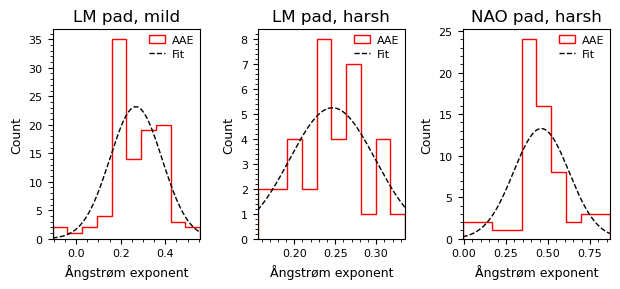

In [3]:
timestamps_124 = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

initial_guess = {
    'p': 1,  
    'mu': 0.3, 
    'sigma': 0.67}

titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, harsh']

fig, axes = plt.subplots(1, 3, figsize = (6.3, 3))

for i, ax in enumerate(axes):
    df = MA[MA_dict_keys[i]]

    AAE_hist(ax, df, timestamps_124[i], 10, gauss, initial_guess)

    ax.set_title(titles[i])

fig.tight_layout()
fig.savefig('Gaussian_fits/BWP_AAE.png', dpi = 600)

In [77]:
def Chi2_fit(x, y, yerr, fitfunc, **kwargs):
    # Written by Philip Kofoed-Djursner
    # Unbinned log likelihood fitter
    
    def obt(*args):
        chi2 = np.sum(((y-fitfunc(x, *args))/yerr)**2)
        return chi2

    minuit = Minuit(obt, **kwargs, name = [*kwargs]) # Setup; obtimization function, initial variable guesses, names of variables. 
    minuit.errordef = 1 # needed for likelihood fits. No explaination in the documentation.

    minuit.migrad() # Compute the fit
    valuesfit = np.array(minuit.values, dtype = np.float64) # Convert to numpy
    errorsfit = np.array(minuit.errors, dtype = np.float64) # Convert to numpy

    Nvar = len(kwargs)           # Number of variables
    Ndof_fit = len(x) - Nvar

    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit) 

    return valuesfit, errorsfit, Prob_fit

In [5]:

def plot_fitted_mean(ax, timestamps, df, df_keys, timelabel, inst_error, bin_means, bin_edges, cut_point, fitfunc, colors, initial_guess):

    mean, std, error = bin_mean(timestamps, df, df_keys, timelabel, inst_error)

    if bin_edges != None:
        dlogDp = np.log10(bin_edges[1:])-np.log10(bin_edges[:-1])
        mean = mean/dlogDp
        std=std/dlogDp
        error=error/dlogDp

    abs_error = [abs(error) for error in error]

    if cut_point == None:
        ax.errorbar(bin_means, mean, abs_error, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
    else:
        df_mean = pd.DataFrame({'Bin mean': bin_means, 'Concentration': mean, 'Error': abs_error})
        
        lower_cut = df_mean['Bin mean'] < cut_point
        upper_cut = df_mean['Bin mean'] > cut_point

        ax.errorbar(df_mean['Bin mean'][lower_cut], df_mean['Concentration'][lower_cut], df_mean['Error'][lower_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
        ax.errorbar(df_mean['Bin mean'][upper_cut], df_mean['Concentration'][upper_cut], df_mean['Error'][upper_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)

    bin_mean_fit = np.linspace(min(bin_means), max(bin_means), 1000)

    fit_params, fit_errors, Prob = Chi2_fit(bin_means, mean, error, fitfunc, **initial_guess)
    ax.plot(bin_mean_fit, fitfunc(bin_mean_fit, *fit_params[:]), color = colors[1], ls = '--', lw = 1)

    print(fit_params)
    print(Prob)

    return ax, fit_params, fit_errors, df_mean

In [6]:
def gauss(x, p, mu, sigma):
    return p*stats.norm.pdf(x, mu, sigma)

def d_gauss(x, p1, mu1, sigma1, p2, mu2, sigma2):
    return p1*stats.norm.pdf(x, mu1, sigma1) + p2*stats.norm.pdf(x, mu2, sigma2)

def t_gauss(x, p1, mu1, sigma1, p2, mu2, sigma2, p3, mu3, sigma3):
    return p1*stats.norm.pdf(x, mu1, sigma1) + p2*stats.norm.pdf(x, mu2, sigma2) + p3*stats.norm.pdf(x, mu3, sigma3)

def lognorm(x, p, mu, sigma):
    return p*stats.lognorm.pdf(x, scale = mu, s = sigma)

def d_loggauss(x, p1, mu1, sigma1, p2, mu2, sigma2):
    return p1*stats.lognorm.pdf(x, scale = mu1, s = sigma1) + p2*stats.lognorm.pdf(x, scale = mu2, s = sigma2)

def t_loggauss(x, p1, mu1, sigma1, p2, mu2, sigma2, p3, mu3, sigma3):
    return p1*stats.lognorm.pdf(x, scale = mu1, s = sigma1) + p2*stats.lognorm.pdf(x, scale = mu2, s = sigma2) + p3*stats.lognorm.pdf(x, scale = mu3, s = sigma3)

def q_loggauss(x, p1, mu1, sigma1, p2, mu2, sigma2, p3, mu3, sigma3, p4, mu4, sigma4):
    return p1*stats.lognorm.pdf(x, scale = mu1, s = sigma1) + p2*stats.lognorm.pdf(x, scale = mu2, s = sigma2) + p3*stats.lognorm.pdf(x, scale = mu3, s = sigma3) + p4*stats.lognorm.pdf(x, scale = mu4, s = sigma4)

def lognorm_gauss(x, p1, mu1, sigma1, p2, mu2, sigma2):
    return p1*stats.lognorm.pdf(x, scale = mu1, s = sigma1) + p2*stats.norm.pdf(x, mu2, sigma2)

def dlognorm_gauss(x, p1, mu1, sigma1, p2, mu2, sigma2, p3, mu3, sigma3):
    return p1*stats.lognorm.pdf(x, scale = mu1, s = sigma1) + p2*stats.lognorm.pdf(x, scale = mu2, s = sigma2) + p3*stats.norm.pdf(x, mu3, sigma3)

Exp1
[8.17581420e+00 4.90674309e-02 4.33958338e-01 4.71028815e+01
 7.63488499e-01 8.75532635e-01 6.19891275e+01 1.54486195e-01
 4.06700018e-01]
1.5873049875391454e-07
[ 708.65079516    3.39656178    0.84314955 -405.69372134    2.47505063
    0.76653589]
1.3785559846260576e-18
Exp2
[2.49493965e+02 1.45314625e-01 3.61597357e-01 2.22830326e+02
 6.74788438e-01 9.05677214e-01 8.61150972e+01 6.68543857e-02
 5.45900486e-01]
5.475517011024999e-07
[1.55893785e+03 7.02231230e+00 8.48794682e-01 2.50114136e+00
 4.65267494e-01 6.69734357e-01]
5.677774128974886e-12
Exp3
[-2.52587266e+02  2.45953841e-01  9.17252648e-01  3.16401698e+02
  2.64371721e-01  9.47363117e-01 -2.49359958e+01  2.47707264e-01
  1.67895927e-01]
1.185392862103423e-12
[-115.36238016    1.8792287     0.70010403  202.77636889    2.47204396
    0.76095516]
3.0153509679559357e-57
Exp4
[ 9.66102716e+00  3.67074558e-02  3.35719484e-01 -5.91178670e+02
  2.21981516e-01  6.88200278e-01  4.08102783e+02  5.00268165e-01
  8.47918529e-01  4.47

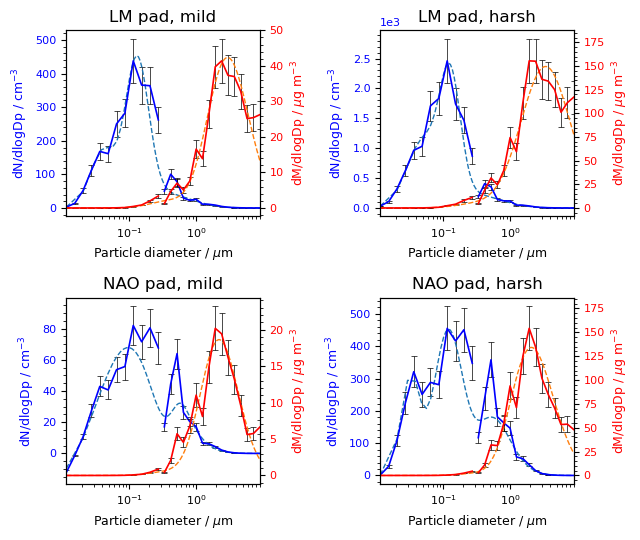

In [79]:
initial_number = [{'p1': 64, 'mu1': 0.14, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.91, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                  {'p1': 64, 'mu1': 0.14, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.91, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                  {'p1': -500, 'mu1': 0.15, 'sigma1': 0.69, 'p2': 400, 'mu2': 0.5, 'sigma2': 0.8, 'p3': -100, 'mu3': 0.05, 'sigma3': 0.33}, 
                  {'p1': 64, 'mu1': 0.03, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.15, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.5, 'sigma3': 0.5, 'p4': 30, 'mu4': 1, 'sigma4': 0.5}]
fit_func_number = [t_loggauss, t_loggauss, dlognorm_gauss, q_loggauss]

initial_mass = [{'p1': 500, 'mu1': 20, 'sigma1': 0.2, 'p2': 10, 'mu2': 1, 'sigma2': 0.5},
                {'p1': 700, 'mu1': 10, 'sigma1': 0.5, 'p2': 10, 'mu2': 1, 'sigma2': 0.5},         # 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                {'p1': 64, 'mu1': 1, 'sigma1': 0.69, 'p2': 40, 'mu2': 3, 'sigma2': 0.8},        # 'p3': -100, 'mu3': 0.05, 'sigma3': 0.33}, 
                {'p1': 64, 'mu1': 1, 'sigma1': 0.67, 'p2': 39, 'mu2': 3, 'sigma2': 0.82}]         #, 'p3': 30, 'mu3': 0.5, 'sigma3': 0.5, 'p4': 30, 'mu4': 1, 'sigma4': 0.5}]
fit_func_mass = [d_loggauss, d_loggauss, d_loggauss, d_loggauss]

titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, mild', 'NAO pad, harsh']
fig, axes = plt.subplots(2, 2, figsize = (6.5, 5.5))

for i, ax in enumerate(axes.flatten()):

    print(dict_keys[i])

    ax, fit_params, fit_errors, df_mean = plot_fitted_mean(ax, timestamps_exp[i], NS_OPS_number[dict_keys[i]], NS_OPS_keys, 'Time', 0.15, 
                                                        NS_OPS_bin_mean, NS_OPS_cut, 0.3, fit_func_number[i], ['b', 'tab:blue'], 
                                                        initial_number[i])
    ax.set(xscale = 'log', title = titles[i], xlabel = 'Particle diameter / $\mu$m')
    ax.set_ylabel('dN/dlogDp / cm$^{-3}$', color = 'b')
    ax.tick_params(axis = 'y', labelcolor = 'b')
    
    ax2 = ax.twinx()
    ax2, fit_params, fit_errors, df_mean = plot_fitted_mean(ax2, timestamps_exp[i], NS_OPS_mass[dict_keys[i]], NS_OPS_keys, 'Time', 0.15, 
                                                        NS_OPS_bin_mean, NS_OPS_cut, 0.3, fit_func_mass[i], ['r', 'tab:orange'],
                                                        initial_mass[i])
    ax2.set_ylabel('dM/dlogDp / $\mu$g m$^{-3}$', color = 'r')
    ax2.tick_params(axis = 'y', labelcolor = 'r')

fig.tight_layout()
fig.savefig('Gaussian_fits/NS_OPS_fitted.png', dpi = 600)